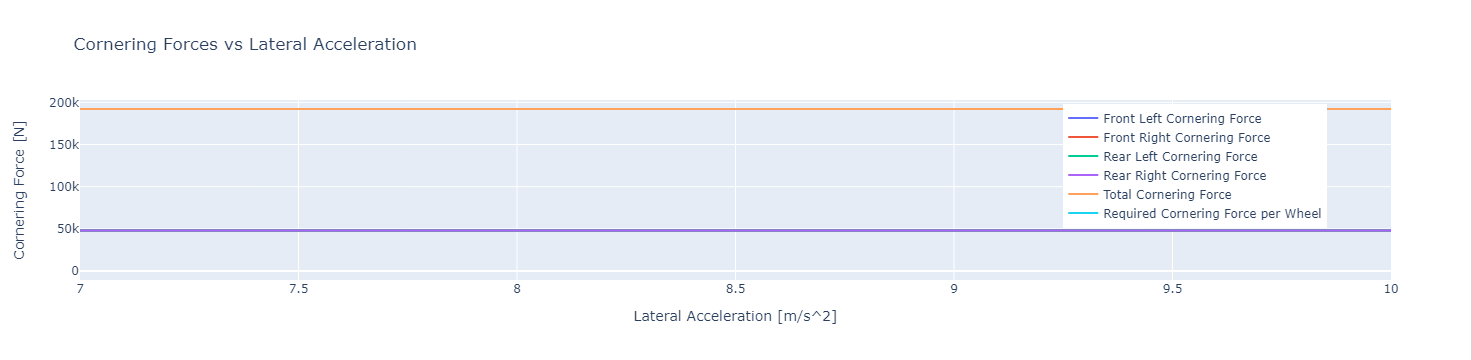

In [12]:
import numpy as np
import plotly.graph_objects as go

def predict_cornering_force(weight, f1, w1, f2, w2, f3, w3):
    """3点の荷重に対応するコーナリングフォースを3次方程式で予測する関数"""
    a = ((weight - w2) * (weight - w3)) / ((w1 - w2) * (w1 - w3))
    b = ((weight - w1) * (weight - w3)) / ((w2 - w1) * (w2 - w3))
    c = ((weight - w1) * (weight - w2)) / ((w3 - w1) * (w3 - w2))
    return f1 * a + f2 * b + f3 * c

# パラメータ設定
mf = 1000.0  # Fr車両質量 [kg]
mr = 1000.0  # Rr車両質量 [kg]
wheelbase = 2.5  # ホイールベース [m]
cg_location = 1.0  # 重心位置（ホイールベースからの距離） [m]
roll_stiffness_front = 20000.0  # ロール剛性（前） [Nm/rad]
roll_stiffness_rear = 30000.0  # ロール剛性（後） [Nm/rad]

# 横加速度の範囲を設定
lateral_accel_range = np.linspace(7, 10, 31)

front_load_l = np.zeros_like(lateral_accel_range)
front_load_r = np.zeros_like(lateral_accel_range)
rear_load_l = np.zeros_like(lateral_accel_range)
rear_load_r = np.zeros_like(lateral_accel_range)
front_cornering_forces_l = np.zeros_like(lateral_accel_range)
front_cornering_forces_r = np.zeros_like(lateral_accel_range)
rear_cornering_forces_l = np.zeros_like(lateral_accel_range)
rear_cornering_forces_r = np.zeros_like(lateral_accel_range)
total_cornering_force = np.zeros_like(lateral_accel_range)

# 各横加速度における各輪の荷重、コーナリングフォース、必要コーナリングフォースを計算（左旋回とする）
for i, lat_accel in enumerate(lateral_accel_range):
    
    # 各輪荷重
    front_load_transfer = roll_stiffness_front * (cg_location / wheelbase) * lateral_accel
    rear_load_transfer = roll_stiffness_rear * ((wheelbase - cg_location) / wheelbase) * lateral_accel

    front_load_l[i] = static_load_front + (car_mass * 9.81 * (1 - static_front_load_ratio)) \
                 - front_load_transfer
    front_load_r[i] = static_load_front + (car_mass * 9.81 * (1 - static_front_load_ratio)) \
                 + front_load_transfer
    rear_load_l[i] = static_load_rear + (car_mass * 9.81 * static_front_load_ratio) \
                - rear_load_transfer
    rear_load_r[i] = static_load_rear + (car_mass * 9.81 * static_front_load_ratio) \
                + rear_load_transfer
    
    # コーナリングフォース
    front_cornering_forces_l[i] = predict_cornering_force(front_load_l[i], 1000, 400, 1500, 500, 2000, 600)
    front_cornering_forces_r[i] = predict_cornering_force(front_load_r[i], 1000, 400, 1500, 500, 2000, 600)
    rear_cornering_forces_l[i] = predict_cornering_force(rear_load_l[i], 1000, 400, 1500, 500, 2000, 600)
    rear_cornering_forces_r[i] = predict_cornering_force(rear_load_r[i], 1000, 400, 1500, 500, 2000, 600)
    total_cornering_force[i] = front_cornering_forces_l[i]+front_cornering_forces_r[i]+rear_cornering_forces_l[i]+rear_cornering_forces_r[i]
    
    # 求心Gに必要なコーナリングフォースを計算
    required_cornering_force = car_mass * lateral_accel

# グラフ表示
fig = go.Figure()

# 4つの輪のそれぞれのコーナリングフォースをプロット
fig.add_trace(go.Scatter(x=lateral_accel_range, y=front_cornering_forces_l,
                         mode='lines', name='Front Left Cornering Force'))
fig.add_trace(go.Scatter(x=lateral_accel_range, y=front_cornering_forces_r,
                         mode='lines', name='Front Right Cornering Force'))
fig.add_trace(go.Scatter(x=lateral_accel_range, y=rear_cornering_forces_l,
                         mode='lines', name='Rear Left Cornering Force'))
fig.add_trace(go.Scatter(x=lateral_accel_range, y=rear_cornering_forces_r,
                         mode='lines', name='Rear Right Cornering Force'))

# コーナリングフォースの合計をプロット
fig.add_trace(go.Scatter(x=lateral_accel_range, y=total_cornering_force,
                         mode='lines', name='Total Cornering Force'))

# 求心Gに必要なコーナリングフォースをプロット
fig.add_trace(go.Scatter(x=lateral_accel_range, y=[required_cornering_force],
                         mode='lines', name='Required Cornering Force per Wheel'))

fig.update_layout(
    title='Cornering Forces vs Lateral Acceleration',
    xaxis_title='Lateral Acceleration [m/s^2]',
    yaxis_title='Cornering Force [N]',
    legend=dict(x=0.75, y=0.98)
)

fig.show()
